# Objective
* 20191002: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost

In [282]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./data/"
filename = "VTI_20130102_20181231.csv"

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


# Common functions

In [283]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [284]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

def pred_xgboost(model, series, N, H):
    """
    Do recursive forecasting using xgboost
    Inputs
        model : the xgboost model
        series: numpy array of shape (len(series),). The time series we want to do recursive forecasting on
        N     : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H     : forecast horizon
    Outputs
        Times series of predictions. Numpy array of shape (H,).
    """
    forecast = series.copy()
    for n in range(H):
        est = model.predict(forecast[-N:].reshape(1,-1))
        forecast = np.append(forecast, est)

    return forecast[-H:]

# Load data

In [285]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,1
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,1
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,1
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,1
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,1


Text(0, 0.5, 'USD')

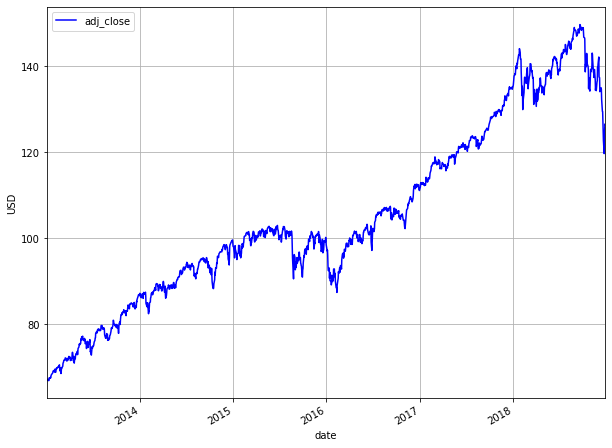

In [286]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [287]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'USD'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=filename)

# Feature Engineering

In [288]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

We use lags up to N number of days to use as features.

In [289]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close']
lag_cols

['adj_close']

In [290]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,date,adj_close,month,order_day,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3
3,2013-01-07,67.060173,1,3,67.238510,66.899689,66.997757
4,2013-01-08,66.881859,1,4,67.060173,67.238510,66.899689
5,2013-01-09,67.086937,1,5,66.881859,67.060173,67.238510
6,2013-01-10,67.550591,1,6,67.086937,66.881859,67.060173
7,2013-01-11,67.559486,1,7,67.550591,67.086937,66.881859


In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 3 to 1508
Data columns (total 7 columns):
date               1506 non-null datetime64[ns]
adj_close          1506 non-null float64
month              1506 non-null int64
order_day          1506 non-null int64
adj_close_lag_1    1506 non-null float64
adj_close_lag_2    1506 non-null float64
adj_close_lag_3    1506 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 94.1 KB


In [292]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [293]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [294]:
cols_list = ["adj_close"]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,month,order_day,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_mean,adj_close_std
3,2013-01-07,67.060173,1,3,67.238510,66.899689,66.997757,NaN,NaN
4,2013-01-08,66.881859,1,4,67.060173,67.238510,66.899689,67.060173,NaN
5,2013-01-09,67.086937,1,5,66.881859,67.060173,67.238510,66.971016,0.126087
6,2013-01-10,67.550591,1,6,67.086937,66.881859,67.060173,67.009656,0.111482
7,2013-01-11,67.559486,1,7,67.550591,67.086937,66.881859,67.173129,0.342597


# Predict for a specific H (forecast horizon) and a specific date

In [295]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-06 00:00:00, with forecast horizon H = 21


## Split into train, and test

In [296]:
train = df[i-train_val_size:i]
test = df[i:i+H]
print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

train.shape = (1008, 9)
test.shape = (21, 9)


## Scale the train, and test set

In [297]:
cols_to_scale = ["adj_close"]

for n in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(n))
    
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_)) # Gives the mean of each column
print("scaler.var_ = " + str(scaler.var_))   # Give the var of each column

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [92.51570599 92.47071071 92.42515946 92.3805562 ]
scaler.var_ = [119.27472465 119.50663736 119.74263087 120.0035649 ]
train_scaled.shape = (1008, 6)


,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,date,month
0,-2.330816,-2.308124,-2.332649,-2.317088,2013-01-07,1
1,-2.347143,-2.324437,-2.301686,-2.326040,2013-01-08,1
2,-2.328365,-2.340749,-2.317983,-2.295110,2013-01-09,1
3,-2.285911,-2.321989,-2.334278,-2.311390,2013-01-10,1
4,-2.285097,-2.279576,-2.315537,-2.327667,2013-01-11,1


In [298]:
# # Do scaling for test set
# test_scaled = test[['date']]
# for col in tqdm_notebook(cols_list):
#     feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
#     temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
#     test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# # Now the entire test set is scaled
# test_scaled.head()

## Split into X and y

In [299]:
features = []
for n in range(1,N+1):
    features.append("adj_close_lag_"+str(n))

target = "adj_close"

# Split into X and y
X_train = train[features]
y_train = train[target]
# X_sample = test[features]
# y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
# print("X_sample.shape = " + str(X_sample.shape))
# print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1008, 3)
y_train.shape = (1008,)


In [300]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
# X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
# print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1008, 3)
y_train_scaled.shape = (1008,)


## EDA

In [301]:
# # Plot adjusted close over time
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
# ax.legend(['train', 'dev', 'test'])
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# ax.set_title("Without scaling")

In [302]:
# # Plot adjusted close over time
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
# ax.legend(['train_scaled'])
# ax.set_xlabel("date")
# ax.set_ylabel("USD (scaled)")
# ax.set_title("With scaling")

## Train the model using XGBoost

In [303]:
# Create the model
model = XGBRegressor(objective ='reg:squarederror',
                     seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled.to_numpy(), y_train_scaled.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=100, silent=None, subsample=1, verbosity=1)

## Predict on train set

In [304]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled.to_numpy())
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.600
MAPE on train set = 0.469%


Text(0.5, 1.0, 'Without scaling')

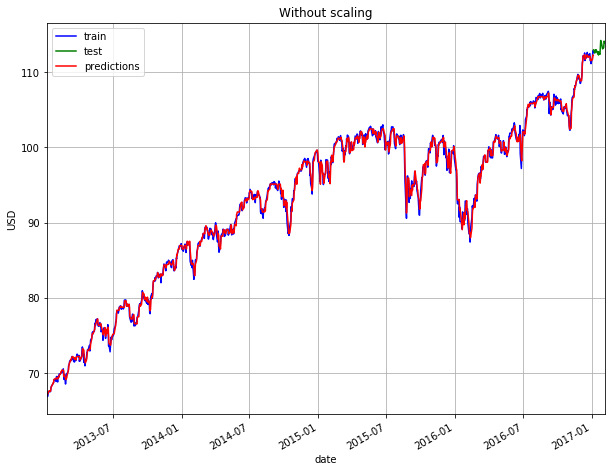

In [305]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

## Predict on test set using recursive forecasting

In [306]:
# Do prediction on test set
est_scaled = pred_xgboost(model, train_scaled['adj_close'].to_numpy(), N, H)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df.iloc[i]['date'], get_rmse(df[i:i+H]['adj_close'], est)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df.iloc[i]['date'], get_mape(df[i:i+H]['adj_close'], est)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df.iloc[i]['date'], get_mae(df[i:i+H]['adj_close'], est)))

For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the RMSE is 1.202384
For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the mean MAPE is 0.910165
For forecast horizon 21, predicting on day 1008, date 2017-01-06 00:00:00, the mean MAE is 1.032300


Text(0, 0.5, 'USD')

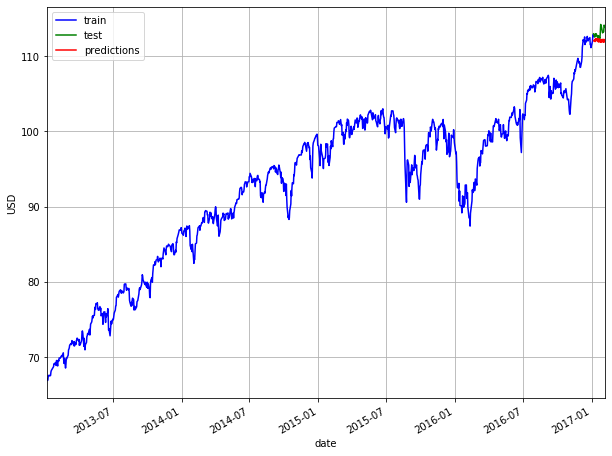

In [307]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': df[i:i+H]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [308]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('adj_close_lag_2', 0.04736483),
 ('adj_close_lag_3', 0.052226443),
 ('adj_close_lag_1', 0.9004087)]

# Findings
* Unscaling the predictions using the mean and variance of the train set does not work well.